# Statistiques sur les données de recensement de 1832

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from scipy import stats

In [2]:
def get_color_list(cmap, n):
    
    values = np.linspace(0, 1, n)
    colors = cmap(values)
    colors = [color[:3] for color in colors]
    return colors

In [3]:
df = pd.read_excel("data/1832_v4.xlsx", index_col=0)
jobs = pd.read_excel("data/histoire urbaine digitale classification metiers.xlsx", na_values="?", sheet_name="data")

In [4]:
df = df[[
    "nom_rue_norm_2",
    "no_maison",
    "proprietaire_nom_norm_2",
    "chef_prenom_norm",
    "chef_nom_norm_2",
    "chef_annee_naissance",
    "epouse_nom_norm",
    "epouse_annee_naissance",
    "enfants_dans_la_commune_prenom_norm",
    "enfants_annee_naissance",
    "chef_origine_norm_2",
    "chef_annee_arrivee",
    "chef_vocation_norm_2",
    "pensionnaires_prenom_norm",
    "pensionnaires_nom_norm",
    "pensionnaires_origine_norm",
    "Page"
]]

In [5]:
# remove "_norm_2" from all column names
df.columns = [re.sub("_norm_2", "", col) for col in df.columns]
# remove "_norm" from all column names
df.columns = [re.sub("_norm", "", col) for col in df.columns]

In [6]:
df.columns

Index(['nom_rue', 'no_maison', 'proprietaire_nom', 'chef_prenom', 'chef_nom',
       'chef_annee_naissance', 'epouse_nom', 'epouse_annee_naissance',
       'enfants_dans_la_commune_prenom', 'enfants_annee_naissance',
       'chef_origine', 'chef_annee_arrivee', 'chef_vocation',
       'pensionnaires_prenom', 'pensionnaires_nom', 'pensionnaires_origine',
       'Page'],
      dtype='object')

In [7]:
# Join df and jobs with chef_vocation in df and JOB in jobs
df = df.join(jobs.set_index("JOB"), on="chef_vocation", how="left")
# rename the CLASS column as chef_vocation_class
df = df.rename(columns={"CLASS": "chef_vocation_class"})

In [8]:
df[["chef_vocation", "chef_vocation_class"]]

,chef_vocation,chef_vocation_class
1,charon,NaN
2,marechal-ferrant,artisanat
3,lingere,service
4,rentier,rente
5,garcon voiturier,NaN
...,...,...
3697,agriculteur,agricole
3698,journalier,agricole
3699,agriculteur,agricole
3700,agriculteur,agricole


In [9]:
jobs[jobs.JOB == "ministre"]

,JOB,CLASS
40,ministre,administration


In [10]:
df.chef_vocation_class.unique()

array([nan, 'artisanat', 'service', 'rente', 'commerce',
       'artisanat/service', 'agricole', 'construction',
       'artisanat/construction', 'administration',
       'construction/artisanat', 'service/construction',
       'service/artisanat'], dtype=object)

In [11]:
df.columns

Index(['nom_rue', 'no_maison', 'proprietaire_nom', 'chef_prenom', 'chef_nom',
       'chef_annee_naissance', 'epouse_nom', 'epouse_annee_naissance',
       'enfants_dans_la_commune_prenom', 'enfants_annee_naissance',
       'chef_origine', 'chef_annee_arrivee', 'chef_vocation',
       'pensionnaires_prenom', 'pensionnaires_nom', 'pensionnaires_origine',
       'Page', 'chef_vocation_class'],
      dtype='object')

In [12]:
df.shape

(3674, 18)

### On ajoute le nombre d'enfants, de pensionnaire et le nombre totale de personne par ménage

On reprend toute la base de données (les 3674 entrées).

Les entrées sont de la forme suivante:
```
Alice|Bob
·
·
Charlie|Dan|Eve
Trudy|·|·|Mallory
```

In [13]:
def count_person(s: str) -> int:
    if s == '·' or s == '.':
        return 0
    return s.count("|") + 1

In [14]:
df["nb_enfants"] = df.enfants_dans_la_commune_prenom.apply(count_person)

In [15]:
df["nb_epouse"] = df.epouse_nom.apply(count_person)
df["nb_pensionnaires"] = df.pensionnaires_nom.apply(count_person)

In [16]:
df["nb_personnes"] = df.nb_enfants + df.nb_epouse + df.nb_pensionnaires + 1

## Statistiques sur l'année de naissance

Les données ne sont pas propres, on a des choses bizarres dans toutes les colonnes. Pour ce faire, on essaie de prendre des données qui semblent propres.

On ne prend que les années de naissances qui ont 4 chiffres.

In [17]:
df_new = df[df.chef_annee_naissance.str.len() == 4]
df_new = df_new[df_new.chef_annee_naissance.str.isnumeric()]
df_new.chef_annee_naissance = df_new.chef_annee_naissance.astype(int)

In [18]:
df_new.shape[0] / df.shape[0]

0.7939575394665215

On obtient 79% des chefs de familles.

In [19]:
df_new.describe()

,chef_annee_naissance,Page,nb_enfants,nb_epouse,nb_pensionnaires,nb_personnes
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,1787.910525,75.427151,1.533425,0.780597,0.791567,4.105588
std,127.003629,41.505349,1.700277,0.450416,1.380005,2.433440
min,1264.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1776.000000,42.000000,0.000000,1.000000,0.000000,2.000000
50%,1787.000000,77.000000,1.000000,1.000000,0.000000,4.000000
75%,1798.000000,109.000000,2.000000,1.000000,1.000000,5.000000
max,7771.000000,151.000000,10.000000,6.000000,30.000000,34.000000


On se rend compte qu'il y a des anomalies encore, des gens nés en 1264 (qui deverait être 1764) et 7771 (qui deverait être 1771).

Remove all people that are negative or less than $0$ years old and people that are more than $100$ years old.

In [20]:
df_new = df_new[(df_new.chef_annee_naissance < 1832) & (df_new.chef_annee_naissance >= 1732)]
print(f"Ratio of values that we keep {df_new.shape[0] / df.shape[0]:%}, number of values that we keep is {df_new.shape[0]}.")

Ratio of values that we keep 78.279804%, number of values that we keep is 2876.


Il nous reste 78% des chefs de familles.

<AxesSubplot:title={'center':'Distribution des années de naissance du chef'}, xlabel='chef_annee_naissance', ylabel='Count'>

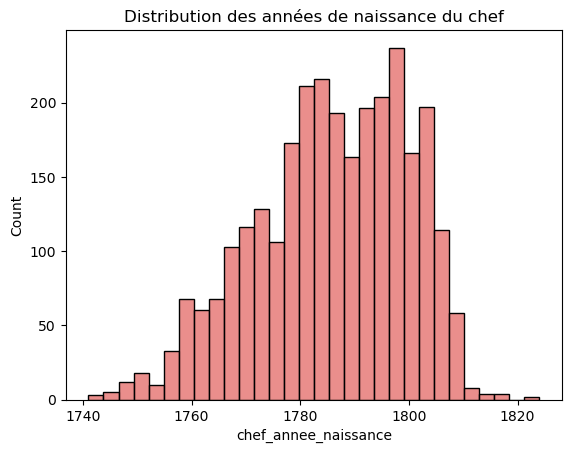

In [21]:
plt.title("Distribution des années de naissance du chef")
sns.histplot(data=df_new, x="chef_annee_naissance", bins=30, color="#e36866")

On effectue du bootstrap pour avoir une estimation de la moyenne et avoir un intervalle de confiance.

In [22]:
# Bootstrap the mean of the chef_annee_naissance column with 10_000 samples
means = []
for i in range(10_000):
    sample = df_new.chef_annee_naissance.sample(frac=1, replace=True)
    means.append(sample.mean())

In [23]:
# Compute the 95% confidence interval of the mean
ci = np.quantile(means, [0.025, 0.975])
ci

array([1785.30563282, 1786.33033727])

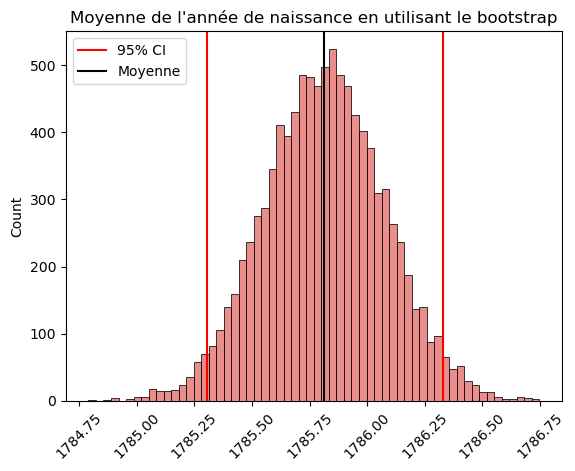

In [24]:
# plot the means with the 95% confidence interval
plt.title("Moyenne de l'année de naissance en utilisant le bootstrap")
sns.histplot(means, color="#e36866")
plt.axvline(ci[0], color="red", label="95% CI")
plt.axvline(ci[1], color="red")
plt.legend()
plt.xticks(rotation=45)
plt.axvline(np.mean(means), color="black", label=f"Moyenne")
plt.legend()
plt.show()

In [25]:
# indicate the mean year of birth of the chef de famille with the 95% confidence interval
print(f"La moyenne des années de naissance des chefs de famille est de {np.mean(means):.2f} avec un intervalle de confiance de 95% de {ci[0]:.2f} à {ci[1]:.2f}.")
print(f"Cela s'écrirait donc {np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne des années de naissance des chefs de famille est de 1785.81 avec un intervalle de confiance de 95% de 1785.31 à 1786.33.
Cela s'écrirait donc 1785.8 ± 0.5.


In [26]:
# The mean age of the chef de famille
print(f"La moyenne d'âge des chefs de famille est de {1832 - np.mean(means):.2f} avec un intervalle de confiance de 95% de {1832 - ci[0]:.2f} à {1832 - ci[1]:.2f}.")
print(f"Cela s'écrirait donc {1832 - np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne d'âge des chefs de famille est de 46.19 avec un intervalle de confiance de 95% de 46.69 à 45.67.
Cela s'écrirait donc 46.2 ± 0.5.


In [27]:
df_new.chef_annee_naissance.min(), df_new.chef_annee_naissance.max()

(1741, 1824)

In [28]:
# std of the chef_annee_naissance column
df_new.chef_annee_naissance.std()

14.05622982538033

In [29]:
df_new.chef_annee_naissance.describe()

count    2876.000000
mean     1785.815021
std        14.056230
min      1741.000000
25%      1776.000000
50%      1787.000000
75%      1797.000000
max      1824.000000
Name: chef_annee_naissance, dtype: float64

In [30]:
(1832 - df_new.chef_annee_naissance).describe()

count    2876.000000
mean       46.184979
std        14.056230
min         8.000000
25%        35.000000
50%        45.000000
75%        56.000000
max        91.000000
Name: chef_annee_naissance, dtype: float64

#### La même mais pour les épouses

In [31]:
df_epouses = df[df.epouse_annee_naissance.str.len() == 4]
df_epouses = df_epouses[df_epouses.epouse_annee_naissance.str.isnumeric()]
df_epouses.epouse_annee_naissance = df_epouses.epouse_annee_naissance.astype(int)

In [32]:
df_epouses.shape[0] / df.shape[0]

0.6488840500816548

In [33]:
df_epouses = df_epouses[(df_epouses.epouse_annee_naissance < 1832) & (df_epouses.epouse_annee_naissance >= 1732)]
print(f"Ratio of values that we keep {df_epouses.shape[0] / df.shape[0]:%}, number of values that we keep is {df_epouses.shape[0]}.")

Ratio of values that we keep 64.289603%, number of values that we keep is 2362.


On a un pourcentage plus bas que celui des chefs de familles. Ceci est dû au fait que chaque chef de famille n'a pas forcément d'épouse.

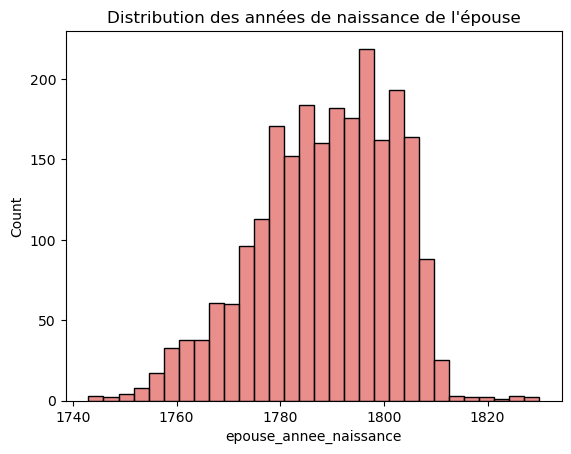

In [34]:
plt.title("Distribution des années de naissance de l'épouse")
sns.histplot(data=df_epouses, x="epouse_annee_naissance", bins=30, color="#e36866")
plt.show()

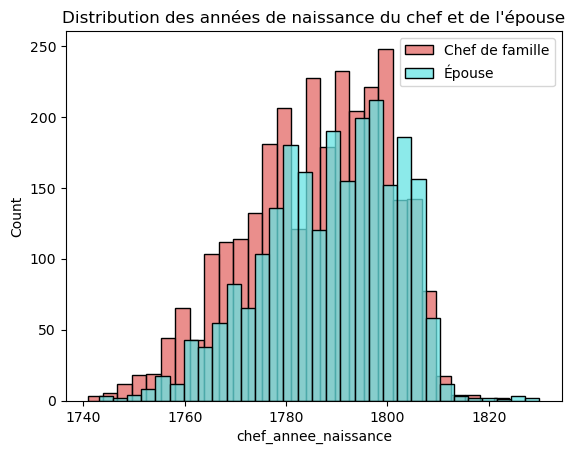

In [35]:
# plot the above two distributions on the same plot
plt.title("Distribution des années de naissance du chef et de l'épouse")
sns.histplot(data=df_new, x="chef_annee_naissance", color="#e36866", label="Chef de famille")
sns.histplot(data=df_epouses, x="epouse_annee_naissance", color="#66e3e3", label="Épouse")
plt.legend()
plt.show()

In [36]:
# Bootstrap the mean of the epouse_annee_naissance column with 10_000 samples 
means = []
for i in range(10_000):
    sample = df_epouses.epouse_annee_naissance.sample(frac=1, replace=True)
    means.append(sample.mean())

In [37]:
# Compute the 95% confidence interval of the mean
ci = np.quantile(means, [0.025, 0.975])
ci

array([1788.17315834, 1789.24006139])

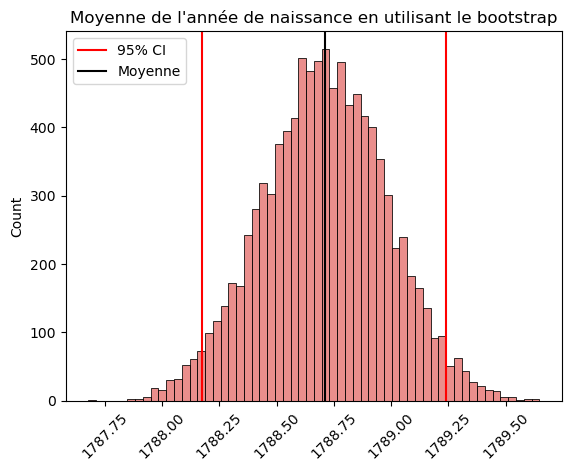

In [38]:
# plot the means with the 95% confidence interval
plt.title("Moyenne de l'année de naissance en utilisant le bootstrap")
sns.histplot(means, color="#e36866")
plt.axvline(ci[0], color="red", label="95% CI")
plt.axvline(ci[1], color="red")
plt.legend()
plt.xticks(rotation=45)
plt.axvline(np.mean(means), color="black", label=f"Moyenne")
plt.legend()
plt.show()

In [39]:
# indicate the mean year of birth of the epouse with the 95% confidence interval
print(f"La moyenne des années de naissance des épouses est de {np.mean(means):.2f} avec un intervalle de confiance de 95% de {ci[0]:.2f} à {ci[1]:.2f}.")
print(f"Cela s'écrirait donc {np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne des années de naissance des épouses est de 1788.71 avec un intervalle de confiance de 95% de 1788.17 à 1789.24.
Cela s'écrirait donc 1788.7 ± 0.5.


In [40]:
# The mean age of the epouse
print(f"La moyenne d'âge des épouses est de {1832 - np.mean(means):.2f} avec un intervalle de confiance de 95% de {1832 - ci[0]:.2f} à {1832 - ci[1]:.2f}.")
print(f"Cela s'écrirait donc {1832 - np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne d'âge des épouses est de 43.29 avec un intervalle de confiance de 95% de 43.83 à 42.76.
Cela s'écrirait donc 43.3 ± 0.5.


## Statistiques sur le nombre d'enfants par famille

In [41]:
df.shape

(3674, 22)

In [42]:
df.nb_enfants.describe()

count    3674.000000
mean        1.443658
std         1.655033
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: nb_enfants, dtype: float64

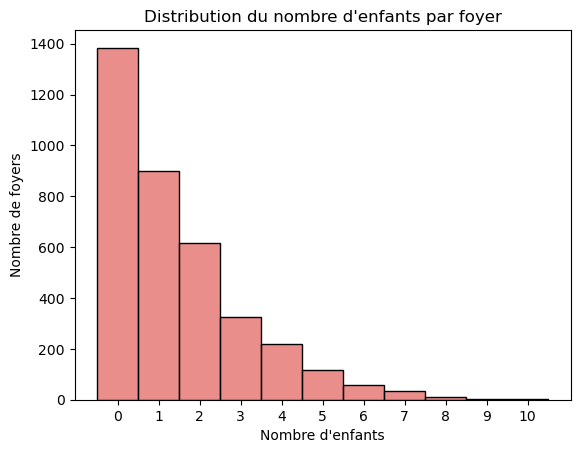

In [43]:
plt.title("Distribution du nombre d'enfants par foyer")
sns.histplot(data=df, x="nb_enfants", discrete=True, color="#e36866")
plt.ylabel("Nombre de foyers")
plt.xlabel("Nombre d'enfants")
plt.xticks(range(0, 11))
plt.show()

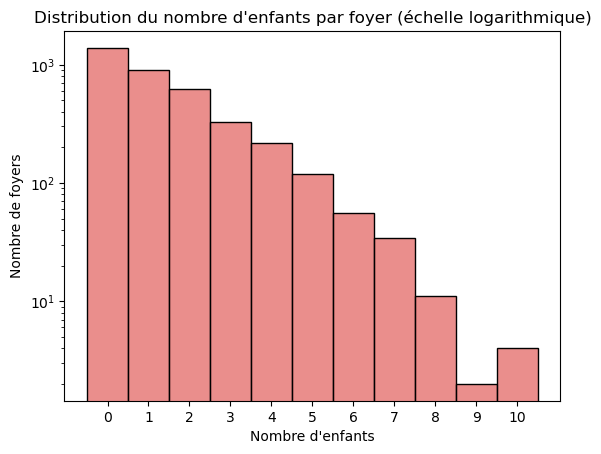

In [44]:
plt.title("Distribution du nombre d'enfants par foyer (échelle logarithmique)")
sns.histplot(data=df, x="nb_enfants", discrete=True, color="#e36866")
plt.ylabel("Nombre de foyers")
plt.xlabel("Nombre d'enfants")
plt.yscale("log")
plt.xticks(range(0, 11))
plt.show()

On peut voir que la distribution du nombre d'enfants par famille suis une loi exponentielle (la distribution est linéaire lorsqu'on la montre avec une échelle logarithmique).

In [45]:
# Bootstrap the mean of the nb_enfants column with 10_000 samples
means = []
for i in range(10_000):
    sample = df.nb_enfants.sample(frac=1, replace=True)
    means.append(sample.mean())

In [46]:
# Compute the 95% confidence interval of the mean
ci = np.quantile(means, [0.025, 0.975])
ci

array([1.3916712, 1.4983669])

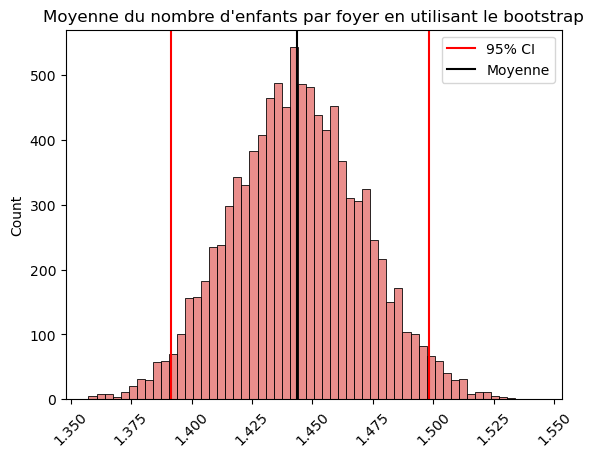

In [47]:
# plot the means with the 95% confidence interval
plt.title("Moyenne du nombre d'enfants par foyer en utilisant le bootstrap")
sns.histplot(means, color="#e36866")
plt.axvline(ci[0], color="red", label="95% CI")
plt.axvline(ci[1], color="red")
plt.legend()
plt.xticks(rotation=45)
plt.axvline(np.mean(means), color="black", label=f"Moyenne")
plt.legend()
plt.show()

In [48]:
# indicate the mean year of birth of the chef de famille with the 95% confidence interval
print(f"La moyenne du nombre d'enfants par foyer est de {np.mean(means):.2f} avec un intervalle de confiance de 95% de {ci[0]:.2f} à {ci[1]:.2f}.")
print(f"Cela s'écrirait donc {np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne du nombre d'enfants par foyer est de 1.44 avec un intervalle de confiance de 95% de 1.39 à 1.50.
Cela s'écrirait donc 1.4 ± 0.1.


## Statistiques sur le nombre de pensionnaires par foyer

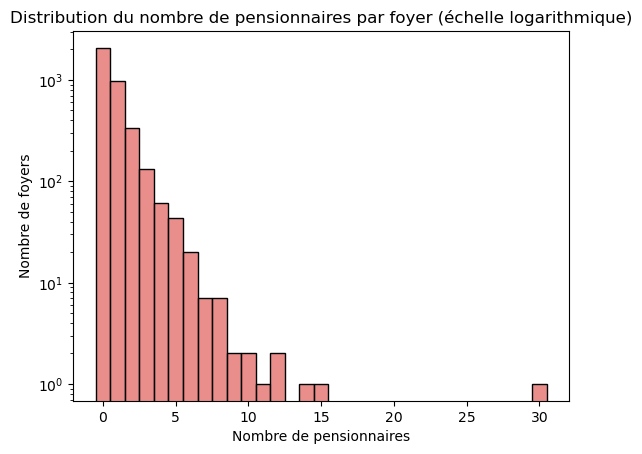

In [75]:
# Plot the distribution of the number of boarder in the households
plt.title("Distribution du nombre de pensionnaires par foyer (échelle logarithmique)")
sns.histplot(data=df, x="nb_pensionnaires", discrete=True, color="#e36866")
plt.ylabel("Nombre de foyers")
plt.xlabel("Nombre de pensionnaires")
plt.yscale("log")
plt.show()

In [ ]:
# Bootstrap the mean of the nb_pensionnaires column with 10_000 samples
means = []
for i in range(10_000):
    sample = df.nb_pensionnaires.sample(frac=1, replace=True)
    means.append(sample.mean())

In [ ]:
# Compute the 95% confidence interval of the mean
ci = np.quantile(means, [0.025, 0.975])
ci

array([0.73788786, 0.82634731])

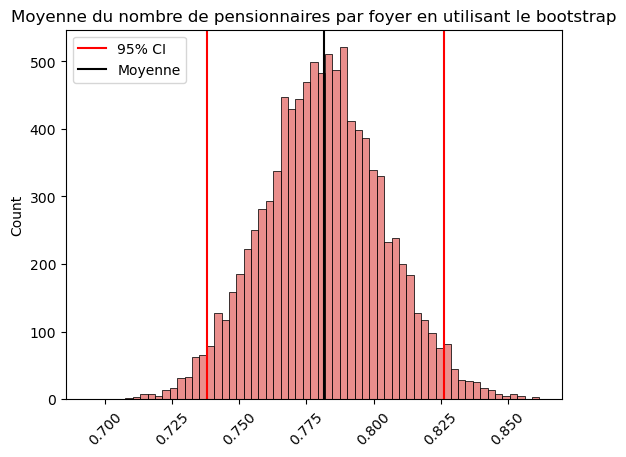

In [ ]:
# plot the means with the 95% confidence interval
plt.title("Moyenne du nombre de pensionnaires par foyer en utilisant le bootstrap")
sns.histplot(means, color="#e36866")
plt.axvline(ci[0], color="red", label="95% CI")
plt.axvline(ci[1], color="red")
plt.legend()
plt.xticks(rotation=45)
plt.axvline(np.mean(means), color="black", label=f"Moyenne")
plt.legend() 
plt.show()

In [ ]:
# indicate the mean number of boarder with the 95% confidence interval
print(f"La moyenne du nombre de pensionnaires par foyer est de {np.mean(means):.2f} avec un intervalle de confiance de 95% de {ci[0]:.2f} à {ci[1]:.2f}.")
print(f"Cela s'écrirait donc {np.mean(means):.2f} ± {np.mean(means) - ci[0]:.2f}.")

La moyenne du nombre de pensionnaires par foyer est de 0.78 avec un intervalle de confiance de 95% de 0.74 à 0.83.
Cela s'écrirait donc 0.78 ± 0.04.


## Nombre de personnes par famille

Pour ce faire, on utiliser l'épouse, les enfants et les pensionnaires.

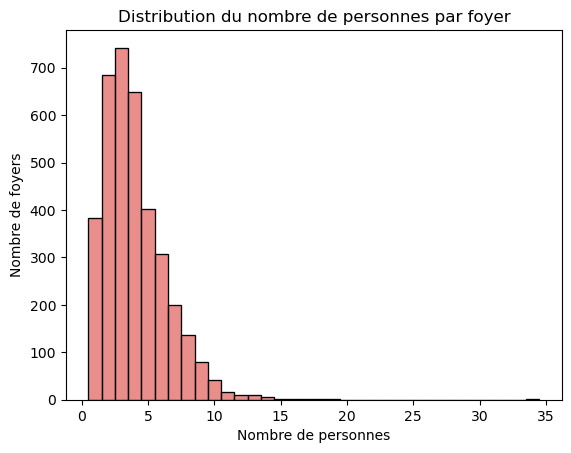

In [49]:
# Plot the distribution of the number of people per household
plt.title("Distribution du nombre de personnes par foyer")
sns.histplot(data=df, x="nb_personnes", discrete=True, color="#e36866")
plt.ylabel("Nombre de foyers")
plt.xlabel("Nombre de personnes")
plt.show()

On pourrait penser à une distribution de poisson.

In [54]:
df.columns

Index(['nom_rue', 'no_maison', 'proprietaire_nom', 'chef_prenom', 'chef_nom',
       'chef_annee_naissance', 'epouse_nom', 'epouse_annee_naissance',
       'enfants_dans_la_commune_prenom', 'enfants_annee_naissance',
       'chef_origine', 'chef_annee_arrivee', 'chef_vocation',
       'pensionnaires_prenom', 'pensionnaires_nom', 'pensionnaires_origine',
       'Page', 'chef_vocation_class', 'nb_enfants', 'nb_epouse',
       'nb_pensionnaires', 'nb_personnes'],
      dtype='object')

In [55]:
df.sort_values("nb_personnes", ascending=False).head(5)[['nom_rue', 'no_maison', 'proprietaire_nom', 'chef_prenom', 'chef_nom',
       'chef_annee_naissance', 'epouse_nom', 'epouse_annee_naissance',
       'chef_origine', 'chef_vocation', 'chef_vocation_class', 'nb_enfants', 'nb_epouse',
       'nb_pensionnaires', 'nb_personnes']]

,nom_rue,no_maison,proprietaire_nom,chef_prenom,chef_nom,chef_annee_naissance,epouse_nom,epouse_annee_naissance,chef_origine,chef_vocation,chef_vocation_class,nb_enfants,nb_epouse,nb_pensionnaires,nb_personnes
3157,barre,·,mathieu,henry,bruch,1800,fler,1800,zurich (canton),instituteur,service,2,1,30,34
3310,petits huttins,·,cerjat,charles,cerjat,1772,·,·,lausanne,proprietaire,rente,7,0,11,19
72,marterey,·,gouvernement,albert,mayor,1773,wolf,1763,echallens,inspecteur de la maison de force,NaN,2,1,15,19
756,bourg,16,gonvers,philippe,gonvers,1791,cougnard,1804,lussy,aubergiste,service,6,1,10,18
1323,rue du pre,31,mercier,jean jaque,mercier,1789,geigle,1796,lausanne,negociant,commerce,5,1,10,17


In [59]:
df.iloc[3130:3139]

,nom_rue,no_maison,proprietaire_nom,chef_prenom,chef_nom,chef_annee_naissance,epouse_nom,epouse_annee_naissance,enfants_dans_la_commune_prenom,enfants_annee_naissance,...,chef_vocation,pensionnaires_prenom,pensionnaires_nom,pensionnaires_origine,Page,chef_vocation_class,nb_enfants,nb_epouse,nb_pensionnaires,nb_personnes
3152,barre,·,panchaud,marguerite,faucherre,1792,·,·,·,·,...,lingere,fuit vener sal,blanc,lausanne,122,service,0,0,1,2
3153,barre,·,panchaud,jean pierre,blanc,1774,henny,1769,jn dl|charlotte|charles,1798|1807|1812,...,journalier,louis|jaques|fena var f recu jn mse,blanc|·|landy,bour de joude,122,agricole,3,1,3,8
3154,barre,·,panchaud,henry,chamot,1799|nneeenne,chapellez,1789,·,·,...,instituteur,·,·,·,122,service,0,1,0,2
3155,barre,46,mathieu,jaques,isler,1772,blumer,1801,·,·,...,rentier?,·,·,·,122,rente,0,1,0,2
3156,barre,·,mathieu,daniel,mathieu,1777,manuel,1788,·,·,...,·,anna|jeannette|reymond franson|neaise,ramel oidpm|eusn jean bram,burtigny|·|st ou chappuis buffat|ont e,122,NaN,0,1,2,4
3157,barre,·,mathieu,henry,bruch,1800,fler,1800,emmu|emilie,1825|1828,...,instituteur,cs al|jean henry|julesade|jacob|charles|cecle ...,rodorf|bloumef|joler|isler|diezigey|brach os|b...,jn juric|glaris|buric|·|·|gloris zuric|st galr...,123,service,2,1,30,34
3158,barre,57,rochat,charles,rochat,1795,gorgerat,1808,louise|albert,1820,...,meunier,·,·,·,123,agricole,2,1,0,4
3159,barre,·,rochat,gge|jan,rochat,1767,couchoux,1762,susette|marianne,1800,...,meunier,ane samuel|jne rose,penguely|vihient,guggisberg|pully le grand,123,agricole,2,1,2,6
3160,barre,42,blanc,pierre|jan,gardel,1778,roux,1773,·,·,...,manœuvre,·,·,·,123,construction,0,1,0,2


On peut voir que la famille d'Henry Bruch, à la rue de la Barre 46, a 34 personnes dans son foyer ! Résulat à prendre avec des pincettes car il peut y avoir des erreurs dans les lingnes comme dit par Arnaud. Il est instituteur.

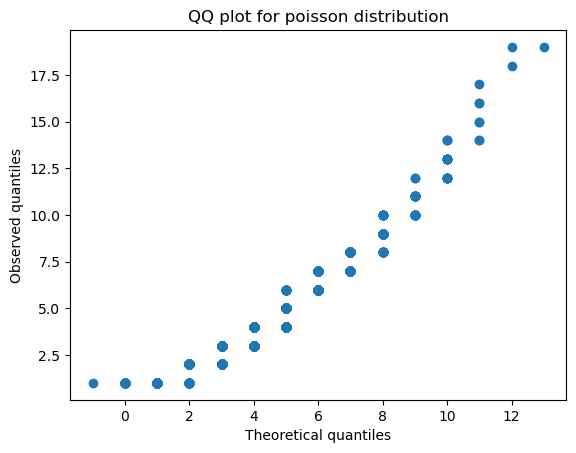

In [60]:
stats.kstest(np.random.normal(size=1000), stats.normaltest).pvalue
from scipy.stats import laplace, poisson, uniform, binom

func = poisson
## plot qqplot for list_coeff laplacian distribution
plt.figure()
plt.title(f'QQ plot for poisson distribution')
plt.ylabel('Observed quantiles')
plt.xlabel('Theoretical quantiles')

theoretical_quantiles = func.ppf(np.linspace(0, 1, len(df.nb_personnes)), mu=df.nb_personnes.mean())
observed_quantiles = np.sort(df.nb_personnes)
plt.plot(theoretical_quantiles, observed_quantiles, 'o')

In [61]:
# Bootstrap the mean of the nb_personnes column with 10_000 samples
means = []
for i in range(10_000):
    sample = df.nb_personnes.sample(frac=1, replace=True)
    means.append(sample.mean())

In [62]:
# Compute the 95% confidence interval of the mean
ci = np.quantile(means, [0.025, 0.975])
ci

array([3.92324442, 4.07566685])

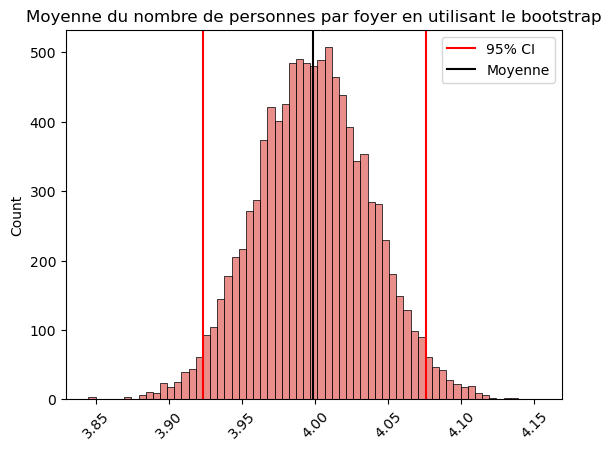

In [63]:
# plot the means with the 95% confidence interval
plt.title("Moyenne du nombre de personnes par foyer en utilisant le bootstrap")
sns.histplot(means, color="#e36866")
plt.axvline(ci[0], color="red", label="95% CI")
plt.axvline(ci[1], color="red")
plt.legend()
plt.xticks(rotation=45)
plt.axvline(np.mean(means), color="black", label=f"Moyenne")
plt.legend()
plt.show()

In [64]:
# Indicate the mean number of person per household with the 95% confidence interval
print(f"La moyenne du nombre de personnes par foyer est de {np.mean(means):.2f} avec un intervalle de confiance de 95% de {ci[0]:.2f} à {ci[1]:.2f}.")
print(f"Cela s'écrirait donc {np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne du nombre de personnes par foyer est de 4.00 avec un intervalle de confiance de 95% de 3.92 à 4.08.
Cela s'écrirait donc 4.0 ± 0.1.


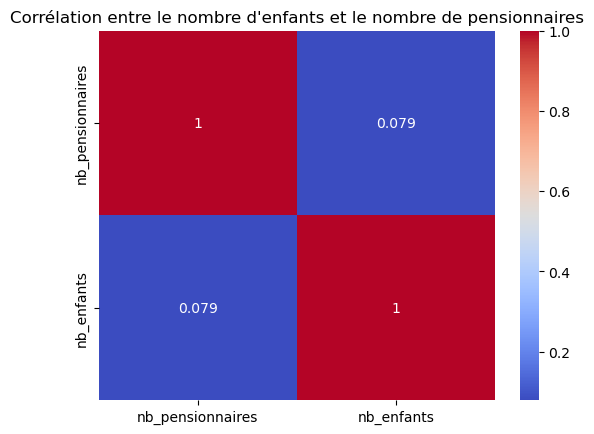

In [65]:
# Find the correlation between the number of people and the number of children
# plot it with a heatmap with values in the cells
corr = df[["nb_pensionnaires", "nb_enfants"]].corr()
plt.title("Corrélation entre le nombre d'enfants et le nombre de pensionnaires")
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

Y'a pas de corrélations du tout, ni positif, ni négatif.

In [136]:
df_corr = df.copy()
df_corr.chef_annee_naissance = df_corr.chef_annee_naissance.astype(str)
df_corr.chef_annee_naissance = df_corr.chef_annee_naissance.apply(lambda x: x if len(x) == 4 and x.isnumeric() and (int(x) >= 1732) & (int(x) <= 1832) else np.nan)
df_corr.chef_annee_naissance = df_corr.chef_annee_naissance.astype(float)#(pd.Int16Dtype())
df["chef_age"] = (1832 - df_corr.chef_annee_naissance).copy()

# do the same as above for the wife
df_corr.epouse_annee_naissance = df_corr.epouse_annee_naissance.astype(str)
df_corr.epouse_annee_naissance = df_corr.epouse_annee_naissance.apply(lambda x: x if len(x) == 4 and x.isnumeric() and (int(x) >= 1732) & (int(x) <= 1832) else np.nan)
df_corr.epouse_annee_naissance = df_corr.epouse_annee_naissance.astype(float)#(pd.Int16Dtype())
df["epouse_age"] = (1832 - df_corr.epouse_annee_naissance).copy()

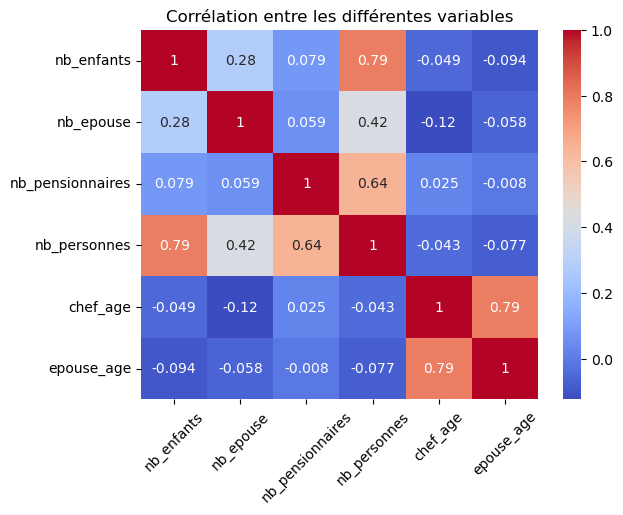

In [137]:
# heatmap of all the numerical columns
corr = df[['nb_enfants', 'nb_epouse', 'nb_pensionnaires', 'nb_personnes', 'chef_age', 'epouse_age']].corr()
plt.title("Corrélation entre les différentes variables")
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(rotation=45)
plt.show()

A part la corrélation entre le nombre d'enfants, de pensionnaires et de personnes dans le foyer, il n'y a aucune autre corrélation. On aurait pu penser à une corrélation entre le nombre d'enfants et le nombre de pensionnaires. Par contre il y a une petite corrélation entre le nombre d'épouse et le nombre d'enfants, qui peut parraitre logique vu qu'un chef de famille seul ou non marié n'aura pas forcément d'enfants. \
Il y a une forte corrélation entre l'âge du chef et l'âge de l'épouse, ce qui est logique. \
Il y a une petite corrélation négative entre l'âge du chef et le fait d'avoir une épouse, ce qui est logique aussi.

## Foyer moyen en 1832 à Lausanne

Un foyer moyen à Lausanne en 1832 est composé de 4 personnes:
- chef de famille qui a 46 ans
- une épouse de 42 ans 
- 1 enfants et
- 1 pensionnaire.

## Statistiques sur les lieux d'origines des chefs de famille

In [77]:
df.chef_origine.shape

(3674,)

In [78]:
origins = df.groupby("chef_origine").size().sort_values(ascending=False)
# drop the index ·
print(f"Nombre d'indéfini {origins.loc['·']}, cela représente {origins.loc['·']/origins.sum():.2%} des données")
origins = origins.drop("·", axis=0)
origins.head()

Nombre d'indéfini 126, cela représente 3.44% des données


chef_origine
lausanne                 622
lutry                    102
corporation francaise     73
epalinges                 68
villette                  53
dtype: int64

In [79]:
# for i in df.groupby("chef_origine").size().sort_values(ascending=False).index:
#     print(i)

0.3304101838755304

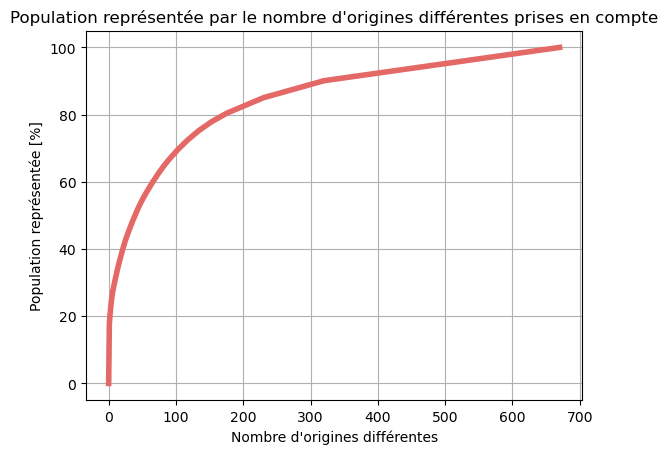

In [80]:
# Get the percentage of the population that is represented by the top 10 origins and plot it as a graph in terms of x
percentages = [origins.head(x).sum() / origins.sum() for x in range(0, len(origins))]
# Plot the above as a line
plt.title("Population représentée par le nombre d'origines différentes prises en compte")
plt.xlabel("Nombre d'origines différentes")
plt.ylabel("Population représentée [%]")
plt.grid(visible=True, which="both")
plt.plot(np.asarray(percentages) * 100,'-',color="#e36866", linewidth=4)
origins.head(12).sum() / origins.sum()

In [81]:
origins[:10].sum()

1104

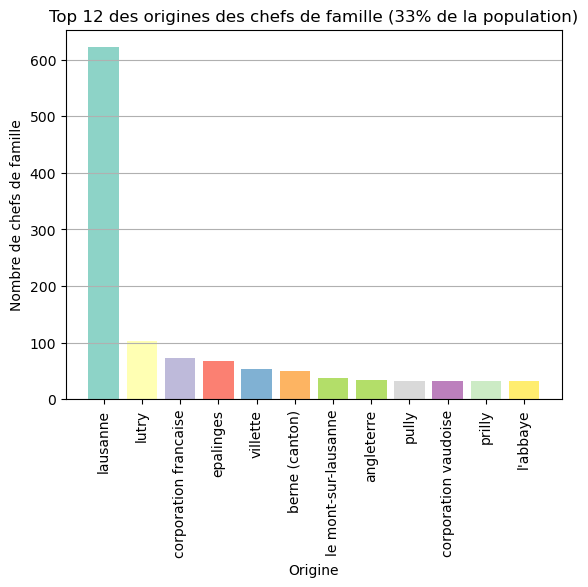

In [82]:
origins_with_others = pd.concat([origins[:12], pd.Series(origins[12:].sum(), index=["Autres"])])
# plot the top 12 origins as a bar chart with the others grouped as "Autres"
plt.title("Top 12 des origines des chefs de famille (33% de la population)")
plt.xlabel("Origine")
plt.ylabel("Nombre de chefs de famille")
# plot only the horizontal grid
plt.grid(visible=True, which="major", axis="y")
plt.bar(origins[:12].index, origins[:12].values, color=get_color_list(plt.cm.Set3, 13))
plt.xticks(rotation=90)
plt.show()

Corporation ?

On a enlevé le point parce qu'il ne represente que ???

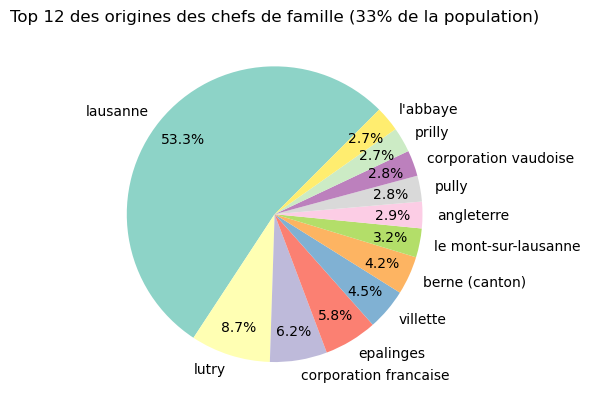

In [83]:
# Make the same plot as above but with the percentage of the population represented by each origin in a pie chart
plt.title("Top 12 des origines des chefs de famille (33% de la population)")
# make the percentages more readable spacing them out$
plt.pie(origins[:12].values, labels=origins[:12].index, autopct="%1.1f%%", colors=get_color_list(plt.cm.Set3, 12), pctdistance=0.8, startangle=45)
plt.show()

Lauranne vs others

In [84]:
# What is the percentage of people comming from Lausanne ?
origins[0] / df.shape[0]

0.1692977681001633

$17\%$ des chefs sont d'origine lausanoise.

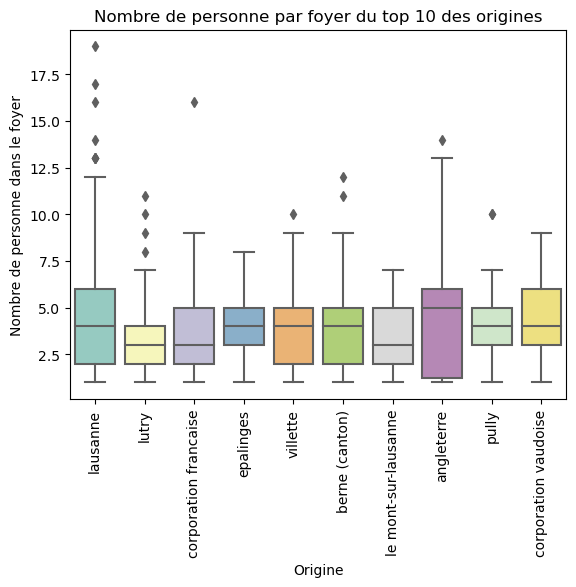

In [167]:
# order the origins by the number of people and plot the top 10
plt.title("Nombre de personne par foyer du top 10 des origines")
sns.boxplot(x="chef_origine", y="nb_personnes", data=df, order=origins.index[:10], palette=get_color_list(plt.cm.Set3, 10))
plt.xlabel("Origine")
plt.ylabel("Nombre de personne dans le foyer")
plt.xticks(rotation=90)
plt.show()

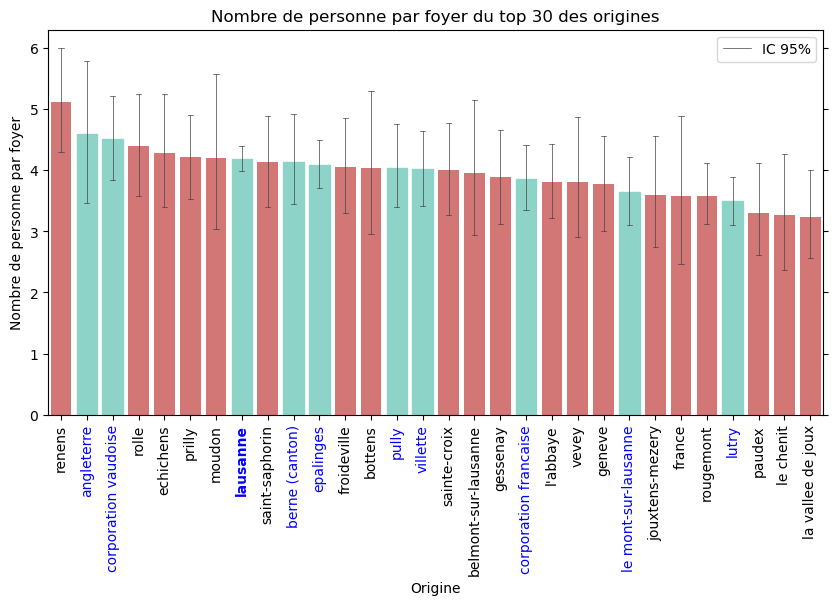

In [219]:
# order the origins by the number of people and plot the top 10
sort = df[df.chef_origine.isin(origins.index[:30])].groupby("chef_origine").mean().sort_values("nb_personnes", ascending=False).nb_personnes.index
plt.figure(figsize=(10, 5))
plt.title("Nombre de personne par foyer du top 30 des origines")
# make the error bars thinner
sns.barplot(x="chef_origine", y="nb_personnes", data=df, order=sort, errorbar=("ci", 95), n_boot=10_000, capsize=0.2, errwidth=0.5, color="#e36866")
plt.xticks(rotation=90)
plt.xlabel("Origine")
plt.ylabel("Nombre de personne par foyer")
plt.legend(["IC 95%"])


for top in origins.index[:10]:
    plt.gca().get_xticklabels()[sort.get_loc(top)].set_color("blue")
    plt.gca().get_children()[sort.get_loc(top)].set_color(get_color_list(plt.cm.Set3, 10)[0])

plt.gca().get_xticklabels()[sort.get_loc("lausanne")].set_fontweight("bold")
# Show y ticks on the right too
plt.gca().yaxis.set_ticks_position("both")
plt.show()

In [186]:
origins.iloc[:30]

chef_origine
lausanne                 622
lutry                    102
corporation francaise     73
epalinges                 68
villette                  53
berne (canton)            49
le mont-sur-lausanne      37
angleterre                34
pully                     33
corporation vaudoise      33
prilly                    32
l'abbaye                  32
vevey                     30
sainte-croix              30
saint-saphorin            28
rolle                     28
jouxtens-mezery           27
paudex                    26
rougemont                 26
gessenay                  26
echichens                 25
moudon                    24
renens                    24
geneve                    23
bottens                   23
la vallee de joux         21
froideville               20
le chenit                 19
belmont-sur-lausanne      19
france                    19
dtype: int64

In [175]:
df[df.chef_origine.isin(origins.index[:20])].groupby("chef_origine").mean().sort_values("nb_personnes", ascending=False).nb_personnes

chef_origine
angleterre               4.588235
corporation vaudoise     4.515152
rolle                    4.392857
prilly                   4.218750
lausanne                 4.191318
berne (canton)           4.142857
saint-saphorin           4.142857
epalinges                4.088235
pully                    4.030303
villette                 4.018868
sainte-croix             4.000000
gessenay                 3.884615
corporation francaise    3.863014
l'abbaye                 3.812500
vevey                    3.800000
le mont-sur-lausanne     3.648649
jouxtens-mezery          3.592593
rougemont                3.576923
lutry                    3.490196
paudex                   3.307692
Name: nb_personnes, dtype: float64

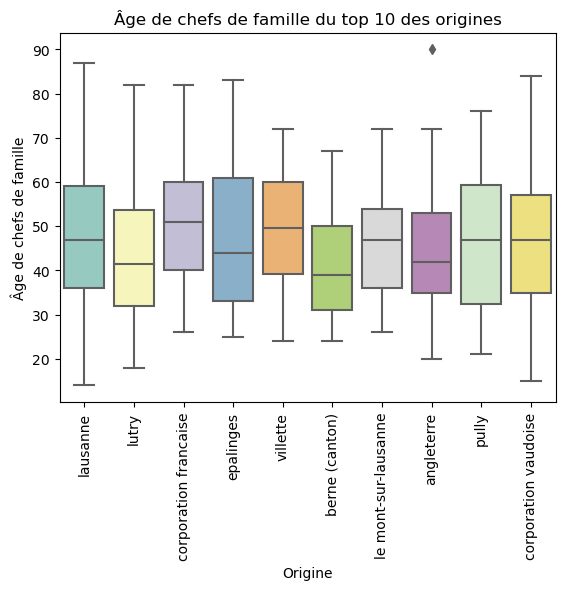

In [164]:
# order the origins by the number of people and plot the top 10
plt.title("Âge de chefs de famille du top 10 des origines")
sns.boxplot(x="chef_origine", y="chef_age", data=df, order=origins.index[:10], palette=get_color_list(plt.cm.Set3, 10))
plt.xticks(rotation=90)
plt.xlabel("Origine")
plt.ylabel("Âge de chefs de famille")
plt.show()

In [155]:
# sort the top origins by the mean chef_age


Index(['corporation francaise', 'villette', 'lausanne', 'epalinges', 'pully',
       'angleterre', 'corporation vaudoise', 'le mont-sur-lausanne', 'lutry',
       'berne (canton)'],
      dtype='object', name='chef_origine')

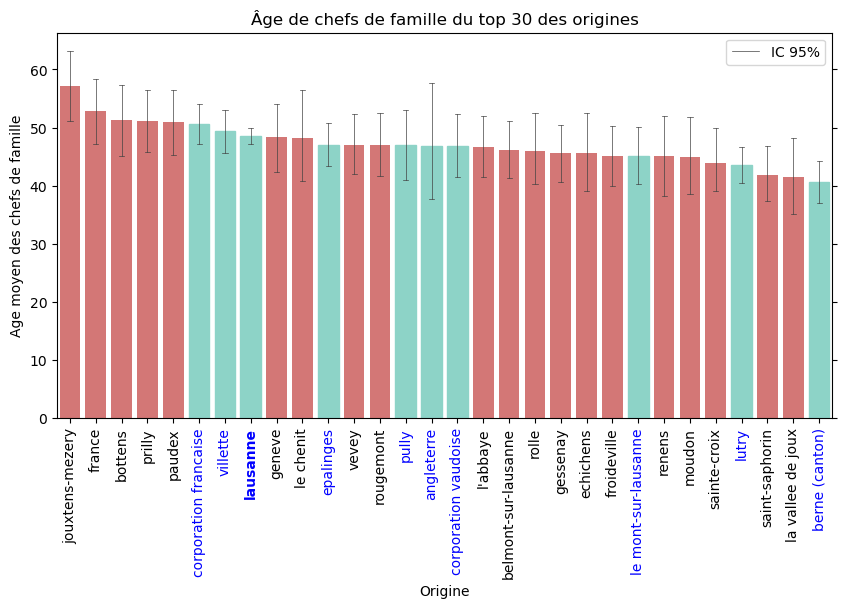

In [218]:
# order the origins by the number of people and plot the top 10
sort = df[df.chef_origine.isin(origins.index[:30])].groupby("chef_origine").mean().sort_values("chef_age", ascending=False).chef_age.index

plt.figure(figsize=(10, 5))
plt.title("Âge de chefs de famille du top 30 des origines")
sns.barplot(x="chef_origine", y="chef_age", data=df, order=sort, errorbar=("ci", 95), n_boot=10_000, capsize=0.2, errwidth=0.5, color="#e36866")
plt.xticks(rotation=90)
plt.xlabel("Origine")
plt.ylabel("Age moyen des chefs de famille")
# put the label of the ci as a label on the graph
plt.legend(["IC 95%"])

for top in origins.index[:10]:
    plt.gca().get_xticklabels()[sort.get_loc(top)].set_color("blue")
    plt.gca().get_children()[sort.get_loc(top)].set_color(get_color_list(plt.cm.Set3, 10)[0])

plt.gca().get_xticklabels()[sort.get_loc("lausanne")].set_fontweight("bold")
# Show y ticks on the right too
plt.gca().yaxis.set_ticks_position("both")
plt.show()

In [171]:
df[df.chef_origine.isin(origins.index[:10])].groupby("chef_origine").mean().sort_values("chef_age", ascending=False).chef_age

chef_origine
corporation francaise    50.525424
villette                 49.354167
lausanne                 48.521739
epalinges                47.033333
pully                    46.923077
angleterre               46.846154
corporation vaudoise     46.827586
le mont-sur-lausanne     45.068966
lutry                    43.500000
berne (canton)           40.589744
Name: chef_age, dtype: float64

c:\Users\Ozan\anaconda3\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\Ozan\anaconda3\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


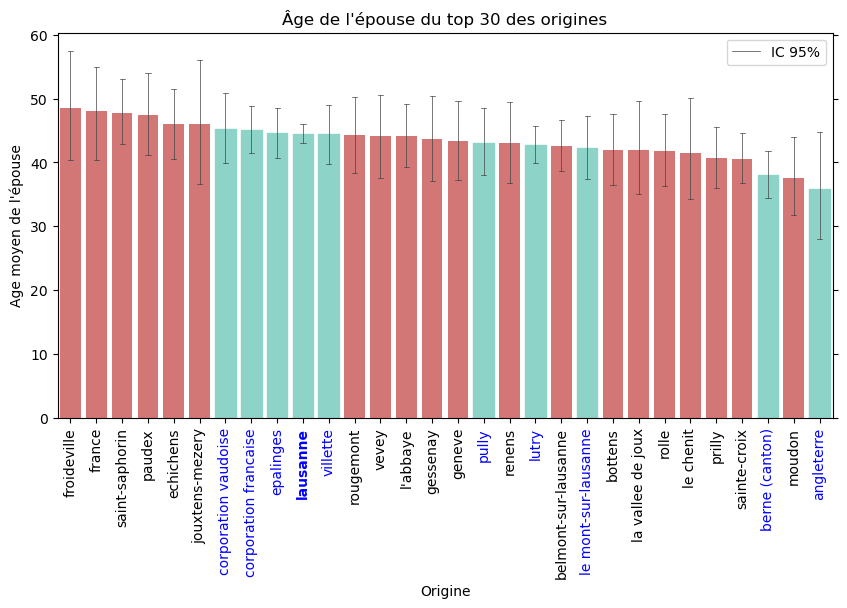

In [223]:
# order the origins by the number of people and plot the top 10
sort = df[df.chef_origine.isin(origins.index[:30])].groupby("chef_origine").mean().sort_values("epouse_age", ascending=False).epouse_age.index

plt.figure(figsize=(10, 5))
plt.title("Âge de l'épouse du top 30 des origines")
sns.barplot(x="chef_origine", y="epouse_age", data=df, order=sort, errorbar=("ci", 95), n_boot=10_000, capsize=0.2, errwidth=0.5, color="#e36866")
plt.xticks(rotation=90)
plt.xlabel("Origine")
plt.ylabel("Age moyen de l'épouse")
# put the label of the ci as a label on the graph
plt.legend(["IC 95%"])

for top in origins.index[:10]:
    plt.gca().get_xticklabels()[sort.get_loc(top)].set_color("blue")
    plt.gca().get_children()[sort.get_loc(top)].set_color(get_color_list(plt.cm.Set3, 10)[0])

plt.gca().get_xticklabels()[sort.get_loc("lausanne")].set_fontweight("bold")
# Show y ticks on the right too
plt.gca().yaxis.set_ticks_position("both")
plt.show()

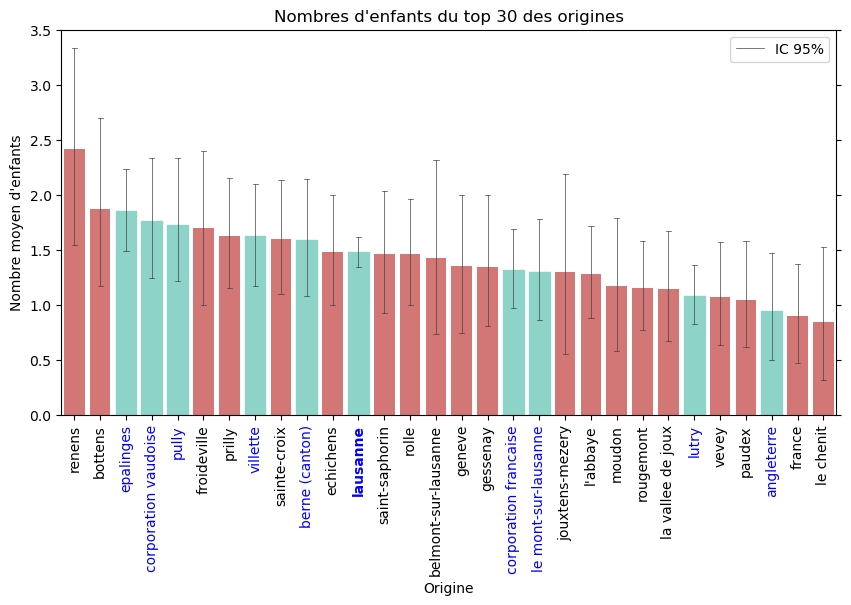

In [224]:
# order the origins by the number of people and plot the top 10
sort = df[df.chef_origine.isin(origins.index[:30])].groupby("chef_origine").mean().sort_values("nb_enfants", ascending=False).nb_enfants.index

plt.figure(figsize=(10, 5))
plt.title("Nombres d'enfants du top 30 des origines")
sns.barplot(x="chef_origine", y="nb_enfants", data=df, order=sort, errorbar=("ci", 95), n_boot=10_000, capsize=0.2, errwidth=0.5, color="#e36866")
plt.xticks(rotation=90)
plt.xlabel("Origine")
plt.ylabel("Nombre moyen d'enfants")
# put the label of the ci as a label on the graph
plt.legend(["IC 95%"])

for top in origins.index[:10]:
    plt.gca().get_xticklabels()[sort.get_loc(top)].set_color("blue")
    plt.gca().get_children()[sort.get_loc(top)].set_color(get_color_list(plt.cm.Set3, 10)[0])

plt.gca().get_xticklabels()[sort.get_loc("lausanne")].set_fontweight("bold")
# Show y ticks on the right too
plt.gca().yaxis.set_ticks_position("both")
plt.show()

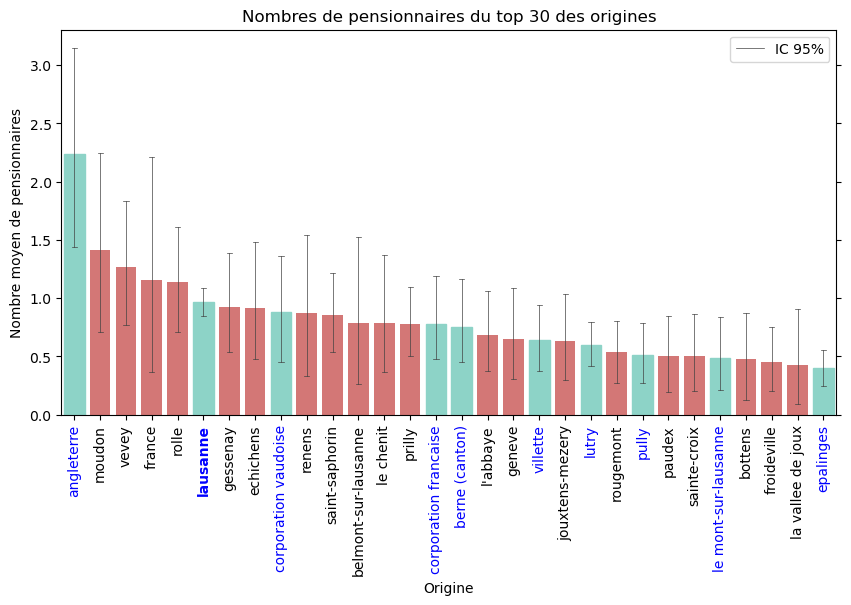

In [225]:
# order the origins by the number of people and plot the top 10
sort = df[df.chef_origine.isin(origins.index[:30])].groupby("chef_origine").mean().sort_values("nb_pensionnaires", ascending=False).nb_pensionnaires.index

plt.figure(figsize=(10, 5))
plt.title("Nombres de pensionnaires du top 30 des origines")
sns.barplot(x="chef_origine", y="nb_pensionnaires", data=df, order=sort, errorbar=("ci", 95), n_boot=10_000, capsize=0.2, errwidth=0.5, color="#e36866")
plt.xticks(rotation=90)
plt.xlabel("Origine")
plt.ylabel("Nombre moyen de pensionnaires")
# put the label of the ci as a label on the graph
plt.legend(["IC 95%"])

for top in origins.index[:10]:
    plt.gca().get_xticklabels()[sort.get_loc(top)].set_color("blue")
    plt.gca().get_children()[sort.get_loc(top)].set_color(get_color_list(plt.cm.Set3, 10)[0])

plt.gca().get_xticklabels()[sort.get_loc("lausanne")].set_fontweight("bold")
# Show y ticks on the right too
plt.gca().yaxis.set_ticks_position("both")
plt.show()

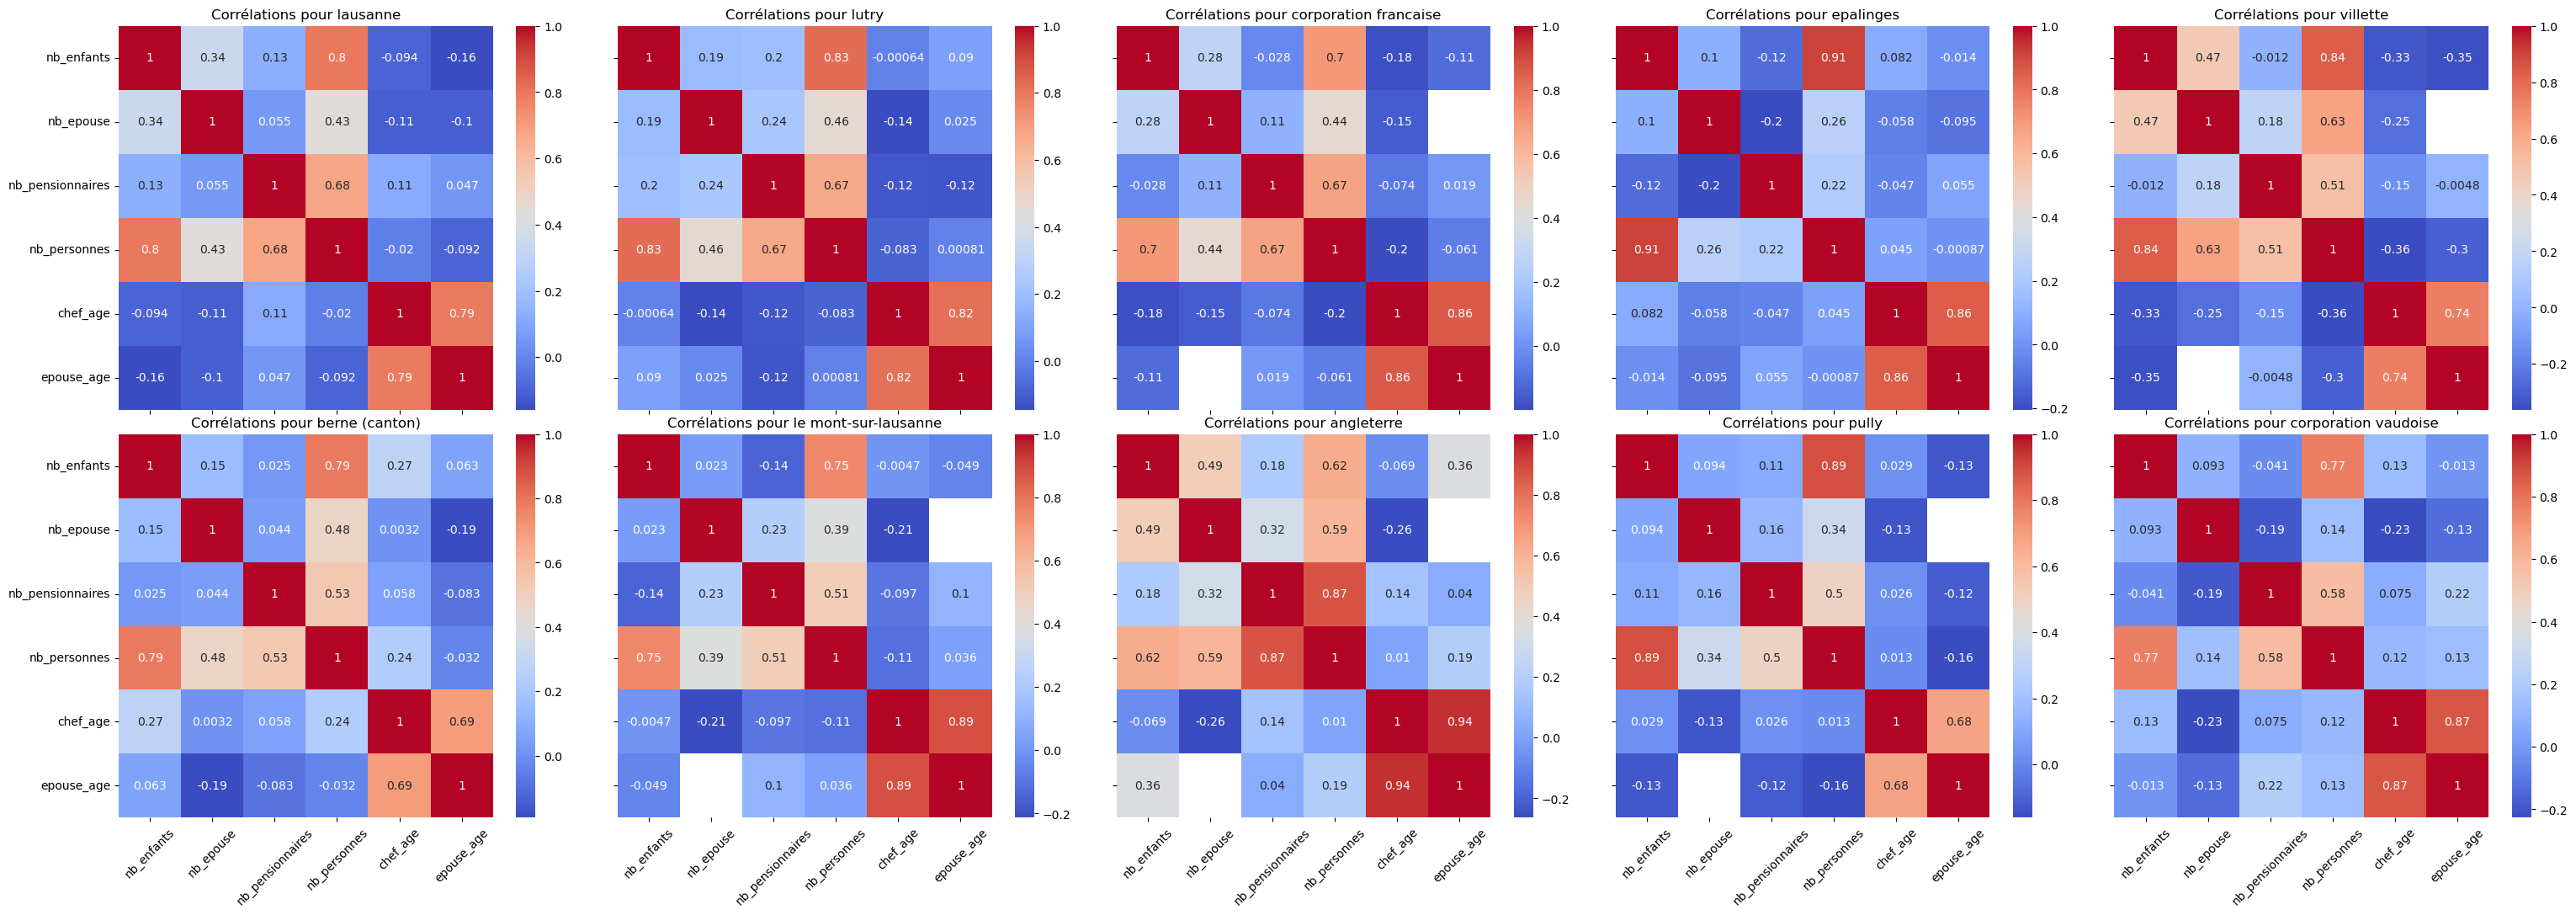

In [238]:
fig, axs = plt.subplots(2, 5, figsize=(30, 10), sharey=True, sharex=True)
fig.tight_layout()
for i, origin in enumerate(origins.index[:10]):
    df_orig = df[df.chef_origine == origin]
    corr = df_orig[['nb_enfants', 'nb_epouse', 'nb_pensionnaires', 'nb_personnes', 'chef_age', 'epouse_age']].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", ax=axs[i//5, i%5], vmin=-1, vmax=1)
    axs[i//5, i%5].set_title(f"Corrélations pour {origin}")
    axs[i//5, i%5].set_xticklabels(axs[i//5, i%5].get_xticklabels(), rotation=45)
plt.show()
 

## Statistiques sur les métiers

In [239]:
df.columns

Index(['nom_rue', 'no_maison', 'proprietaire_nom', 'chef_prenom', 'chef_nom',
       'chef_annee_naissance', 'epouse_nom', 'epouse_annee_naissance',
       'enfants_dans_la_commune_prenom', 'enfants_annee_naissance',
       'chef_origine', 'chef_annee_arrivee', 'chef_vocation',
       'pensionnaires_prenom', 'pensionnaires_nom', 'pensionnaires_origine',
       'Page', 'chef_vocation_class', 'nb_enfants', 'nb_epouse',
       'nb_pensionnaires', 'nb_personnes', 'chef_age', 'epouse_age'],
      dtype='object')

On ne va pas prendre en compte les classes mixtes.

In [275]:
classes = ["agricole", "rente", "artisanat", "service", "commerce", "construction", "administration"]
vocations = df.groupby("chef_vocation_class").size().sort_values(ascending=False)
# drop the index ·
print(f"Nombre d'indéfini {vocations.isna().sum()}, cela représente {vocations.isna().sum()/vocations.sum():.2%} des données")
#print(f"Nombre d'indéfini {vocations.loc['·']}, cela représente {vocations.loc['·']/vocations.sum():.2%} des données")
vocations = vocations.dropna()
#vocations = vocations.drop("·", axis=0)
vocations.head(11)

Nombre d'indéfini 0, cela représente 0.00% des données


chef_vocation_class
agricole                  640
rente                     507
artisanat                 503
service                   465
commerce                  229
construction              225
artisanat/construction    112
administration             63
artisanat/service          31
construction/artisanat     20
service/artisanat          17
dtype: int64

In [276]:
vocations = pd.concat([vocations[classes], pd.Series(vocations.drop(classes).sum(), index=["Autres"])])

0.9109929078014184

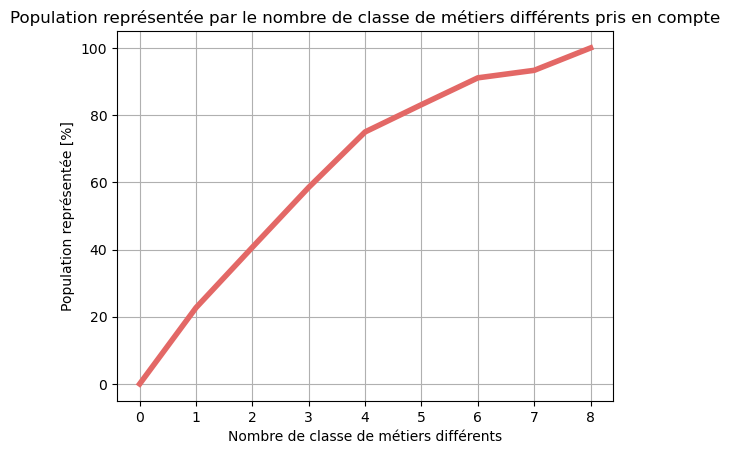

In [279]:
# Get the percentage of the population that is represented by the top 10 origins and plot it as a graph in terms of x
percentages = [vocations.head(x).sum() / vocations.sum() for x in range(0, len(vocations) + 1)]
# Plot the above as a line
plt.title("Population représentée par le nombre de classe de métiers différents pris en compte")
plt.xlabel("Nombre de classe de métiers différents")
plt.ylabel("Population représentée [%]")
plt.grid(visible=True, which="both")
plt.plot(np.asarray(percentages) * 100,'-',color="#e36866", linewidth=4)
vocations.head(6).sum() / vocations.sum()

In [280]:
vocations[:7].sum()

2632

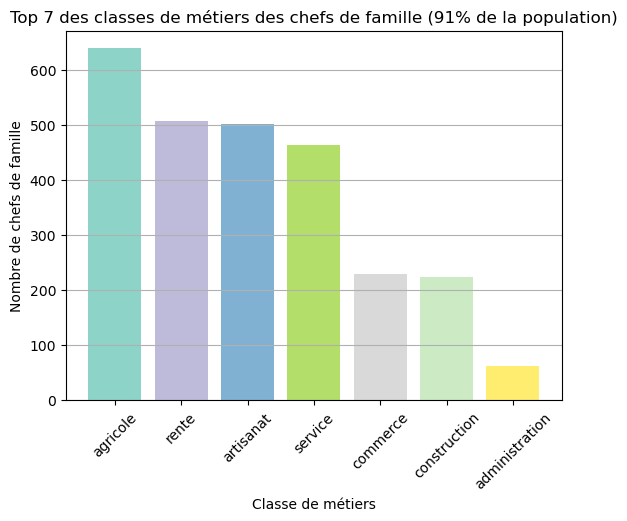

In [281]:
# plot the top 6 origins as a bar chart with the others grouped as "Autres"
plt.title("Top 7 des classes de métiers des chefs de famille (91% de la population)")
plt.xlabel("Classe de métiers")
plt.ylabel("Nombre de chefs de famille")
# plot only the horizontal grid
plt.grid(visible=True, which="major", axis="y")
plt.bar(vocations[:7].index, vocations[:7].values, color=get_color_list(plt.cm.Set3, 7))
plt.xticks(rotation=45)
plt.show()

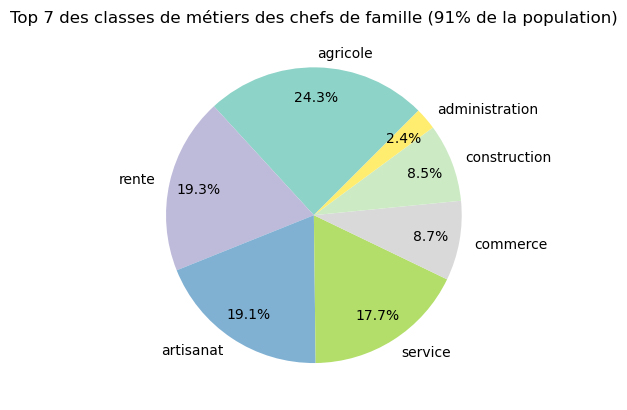

In [285]:
# Make the same plot as above but with the percentage of the population represented by each origin in a pie chart
plt.title("Top 7 des classes de métiers des chefs de famille (91% de la population)")
# make the percentages more readable spacing them out$
plt.pie(vocations[:7].values, labels=vocations[:7].index, autopct="%1.1f%%", colors=get_color_list(plt.cm.Set3, 7), pctdistance=0.8, startangle=45)
plt.show()

In [288]:
# What is the percentage of people working in agricole ?
vocations[0] / df.shape[0]

0.17419706042460534

$17\%$ des chefs travaillent dans l'agriculture, comme le nombre d'origine lausanoise.

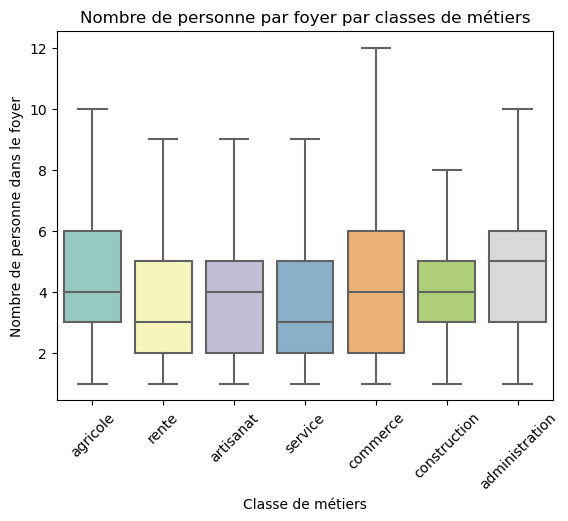

In [294]:
plt.title("Nombre de personne par foyer par classes de métiers")
sns.boxplot(x="chef_vocation_class", y="nb_personnes", data=df, order=vocations.index[:7], palette=get_color_list(plt.cm.Set3, 10), showfliers=False)
plt.xlabel("Classe de métiers")
plt.ylabel("Nombre de personne dans le foyer")
plt.xticks(rotation=45)
plt.show()

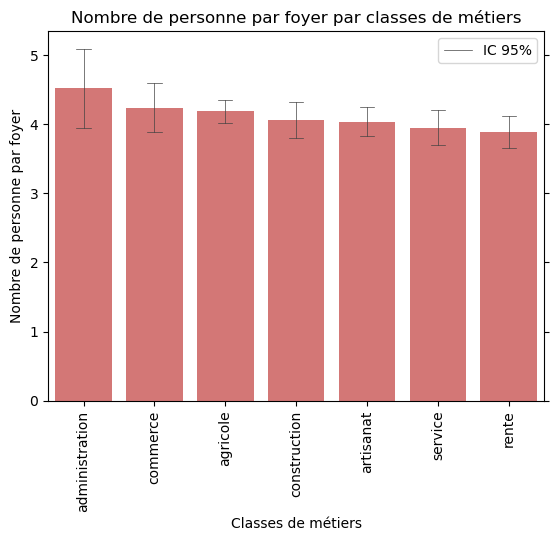

In [303]:
# order the origins by the number of people and plot the top 10
sort = df[df.chef_vocation_class.isin(vocations.index[:7])].groupby("chef_vocation_class").mean().sort_values("nb_personnes", ascending=False).nb_personnes.index

plt.title("Nombre de personne par foyer par classes de métiers")
# make the error bars thinner
sns.barplot(x="chef_vocation_class", y="nb_personnes", data=df, order=sort, errorbar=("ci", 95), n_boot=10_000, capsize=0.2, errwidth=0.5, color="#e36866")
plt.xticks(rotation=90)
plt.xlabel("Classes de métiers")
plt.ylabel("Nombre de personne par foyer")
plt.legend(["IC 95%"])
plt.gca().yaxis.set_ticks_position("both")
plt.show()

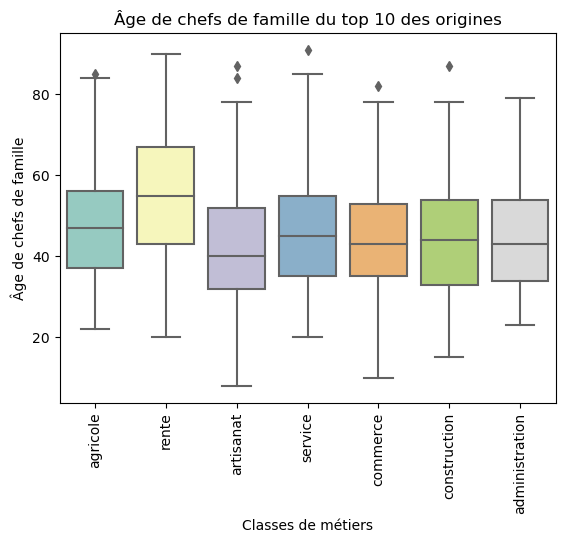

In [304]:
plt.title("Âge de chefs de famille du top 10 des origines")
sns.boxplot(x="chef_vocation_class", y="chef_age", data=df, order=vocations.index[:7], palette=get_color_list(plt.cm.Set3, 10))
plt.xticks(rotation=90)
plt.xlabel("Classes de métiers")
plt.ylabel("Âge de chefs de famille")
plt.show()

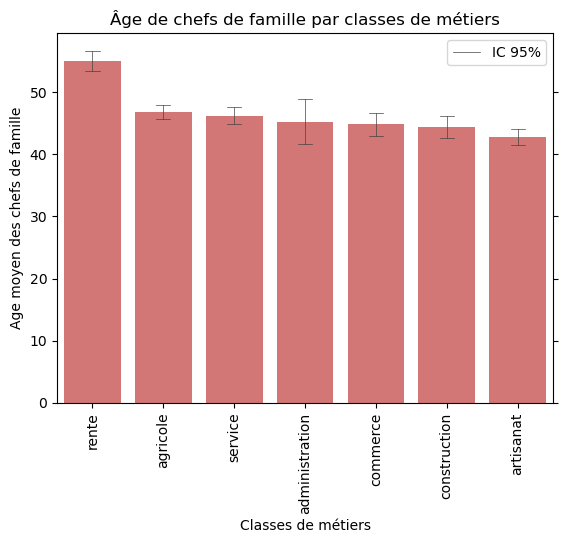

In [305]:
# order the origins by the number of people and plot the top 10
sort = df[df.chef_vocation_class.isin(vocations.index[:7])].groupby("chef_vocation_class").mean().sort_values("chef_age", ascending=False).chef_age.index

plt.title("Âge de chefs de famille par classes de métiers")
# make the error bars thinner
sns.barplot(x="chef_vocation_class", y="chef_age", data=df, order=sort, errorbar=("ci", 95), n_boot=10_000, capsize=0.2, errwidth=0.5, color="#e36866")
plt.xticks(rotation=90)
plt.xlabel("Classes de métiers")
plt.ylabel("Age moyen des chefs de famille")
plt.legend(["IC 95%"])
plt.gca().yaxis.set_ticks_position("both")
plt.show()

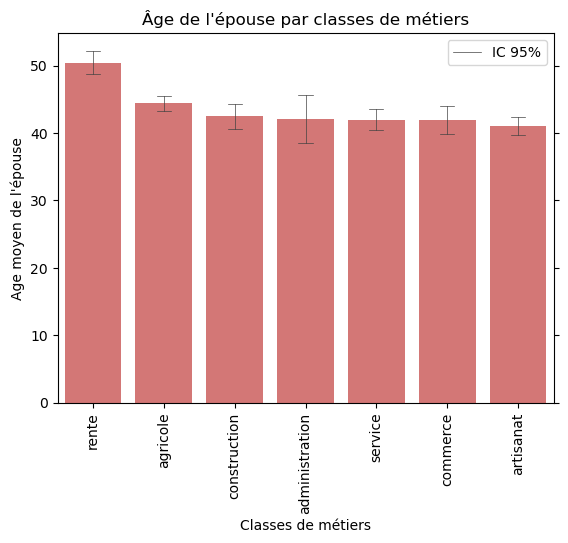

In [306]:
# order the origins by the number of people and plot the top 10
sort = df[df.chef_vocation_class.isin(vocations.index[:7])].groupby("chef_vocation_class").mean().sort_values("epouse_age", ascending=False).epouse_age.index

plt.title("Âge de l'épouse par classes de métiers")
# make the error bars thinner
sns.barplot(x="chef_vocation_class", y="epouse_age", data=df, order=sort, errorbar=("ci", 95), n_boot=10_000, capsize=0.2, errwidth=0.5, color="#e36866")
plt.xticks(rotation=90)
plt.xlabel("Classes de métiers")
plt.ylabel("Age moyen de l'épouse")
plt.legend(["IC 95%"])
plt.gca().yaxis.set_ticks_position("both")
plt.show()

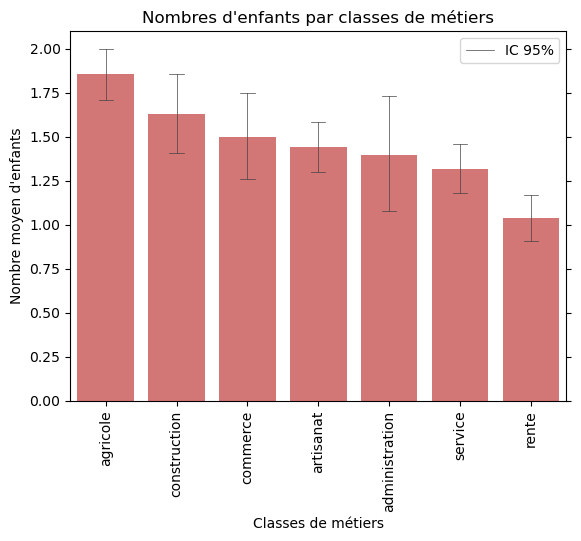

In [307]:
# order the origins by the number of people and plot the top 10
sort = df[df.chef_vocation_class.isin(vocations.index[:7])].groupby("chef_vocation_class").mean().sort_values("nb_enfants", ascending=False).nb_enfants.index

plt.title("Nombres d'enfants par classes de métiers")
# make the error bars thinner
sns.barplot(x="chef_vocation_class", y="nb_enfants", data=df, order=sort, errorbar=("ci", 95), n_boot=10_000, capsize=0.2, errwidth=0.5, color="#e36866")
plt.xticks(rotation=90)
plt.xlabel("Classes de métiers")
plt.ylabel("Nombre moyen d'enfants")
plt.legend(["IC 95%"])
plt.gca().yaxis.set_ticks_position("both")
plt.show()

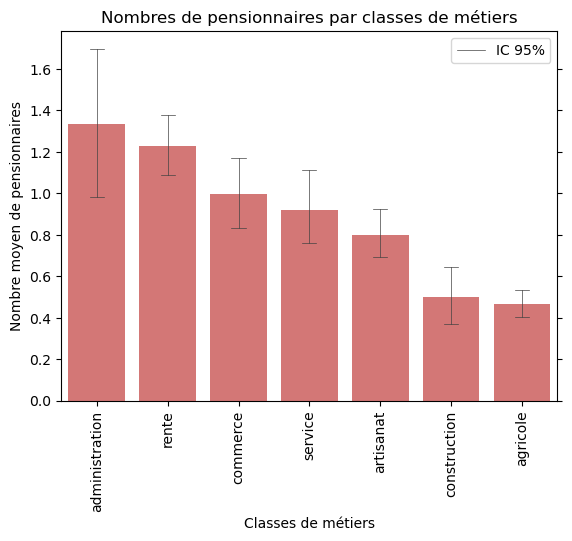

In [308]:
# order the origins by the number of people and plot the top 10
sort = df[df.chef_vocation_class.isin(vocations.index[:7])].groupby("chef_vocation_class").mean().sort_values("nb_pensionnaires", ascending=False).nb_pensionnaires.index

plt.title("Nombres de pensionnaires par classes de métiers")
# make the error bars thinner
sns.barplot(x="chef_vocation_class", y="nb_pensionnaires", data=df, order=sort, errorbar=("ci", 95), n_boot=10_000, capsize=0.2, errwidth=0.5, color="#e36866")
plt.xticks(rotation=90)
plt.xlabel("Classes de métiers")
plt.ylabel("Nombre moyen de pensionnaires")
plt.legend(["IC 95%"])
plt.gca().yaxis.set_ticks_position("both")
plt.show()

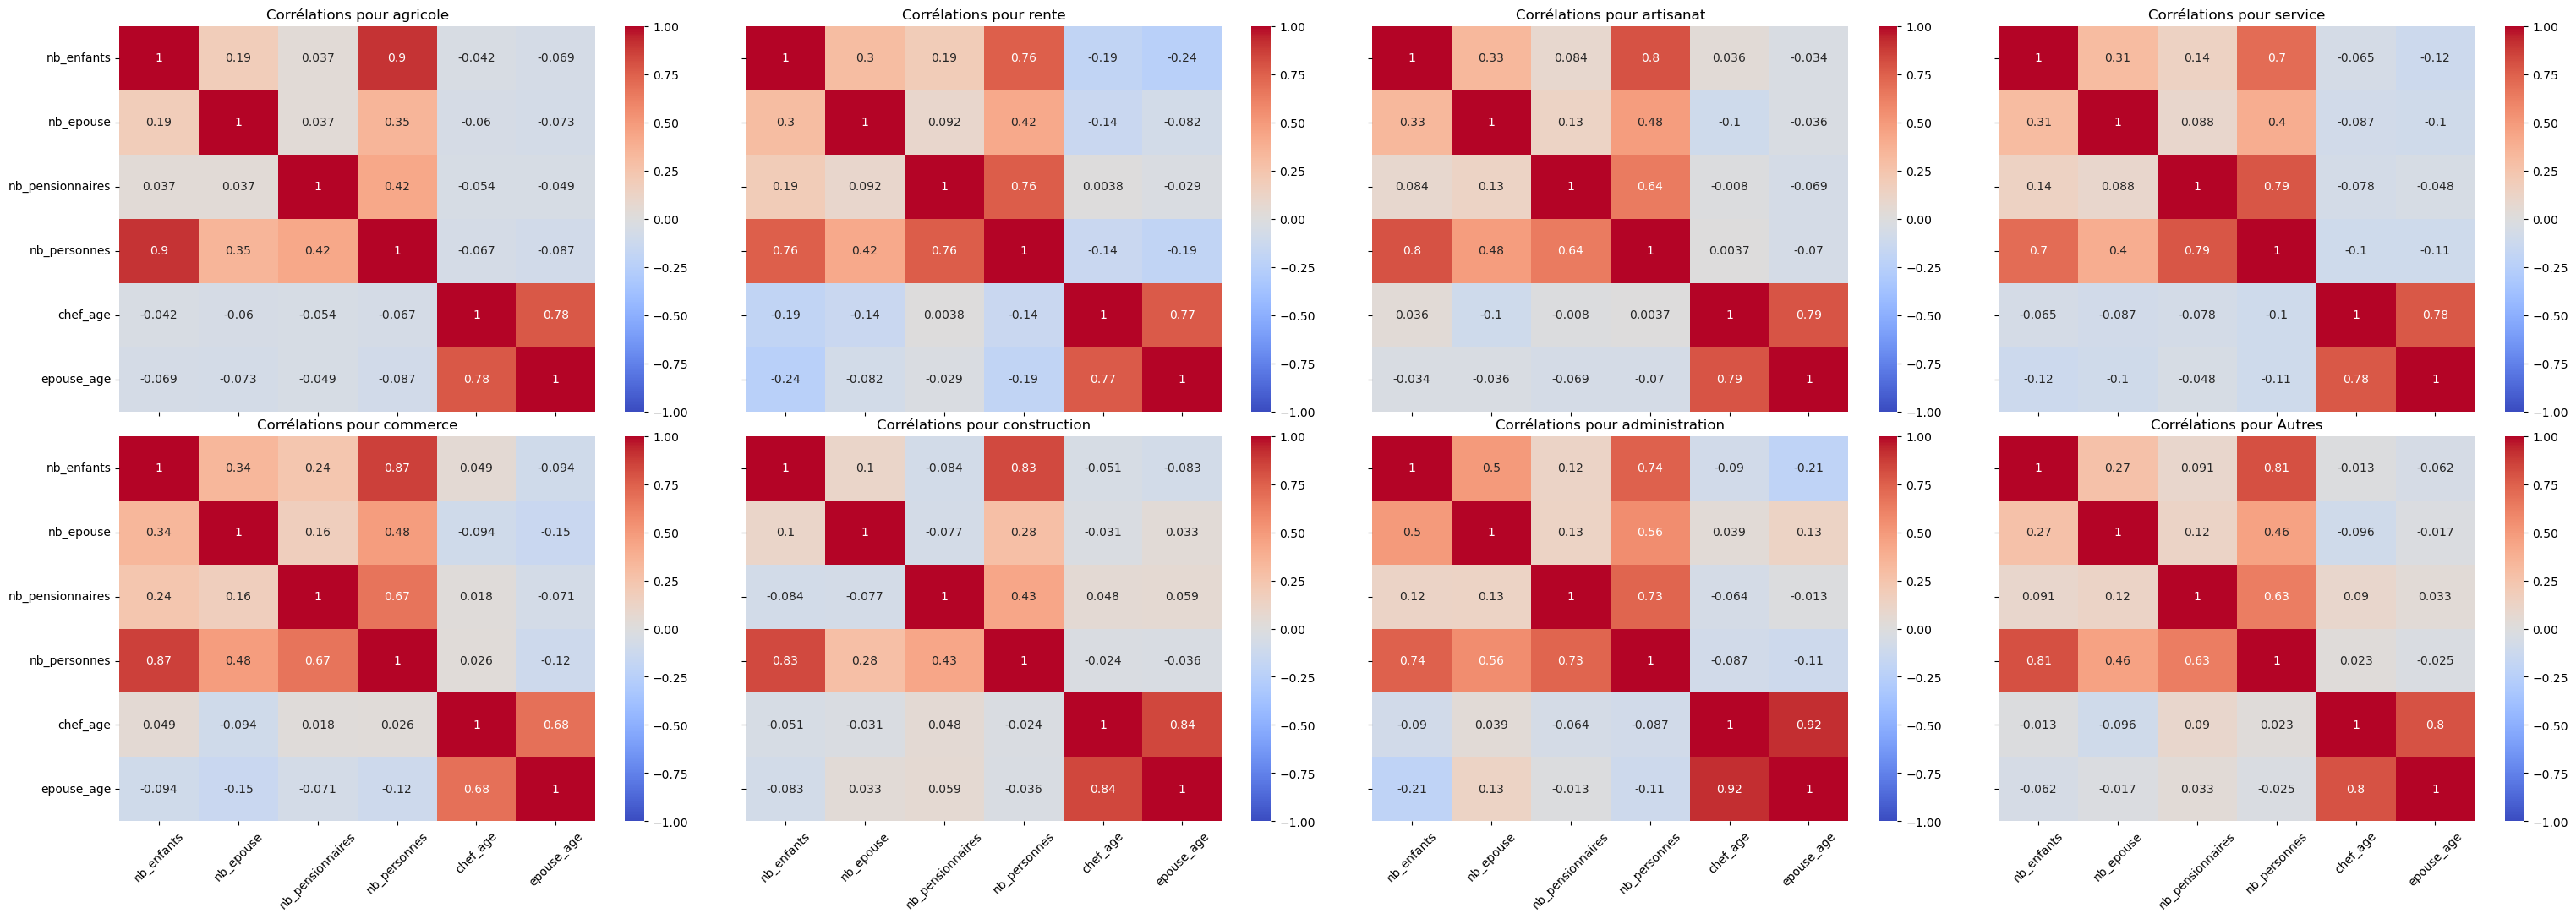

In [326]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(30, 10), sharex=True)
fig.tight_layout()
for ax, _class in zip(axs.ravel(), vocations.index):
    df_orig = df[df.chef_vocation_class == _class] if _class != "Autres" else df[~df.chef_vocation_class.isin(vocations.index[:7])]
    corr = df_orig[['nb_enfants', 'nb_epouse', 'nb_pensionnaires', 'nb_personnes', 'chef_age', 'epouse_age']].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax, vmin=-1, vmax=1)
    ax.set_title(f"Corrélations pour {_class}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()
 

In [119]:
# Bootstrap the mean of the chef_annee_naissance that have "administration" as chef_vocation_class with 10_000 samples
means_administration = []
for i in range(10_000):
    sample = df_new[df_new.chef_vocation_class == "administration"].chef_annee_naissance.sample(frac=1, replace=True)
    means_administration.append(sample.mean())
    
# Bootstrap the mean of the chef_annee_naissance that have "construction" as chef_vocation_class with 10_000 samples
means_construction = []
for i in range(10_000):
    sample = df_new[df_new.chef_vocation_class == "construction"].chef_annee_naissance.sample(frac=1, replace=True)
    means_construction.append(sample.mean())

<AxesSubplot:ylabel='Count'>

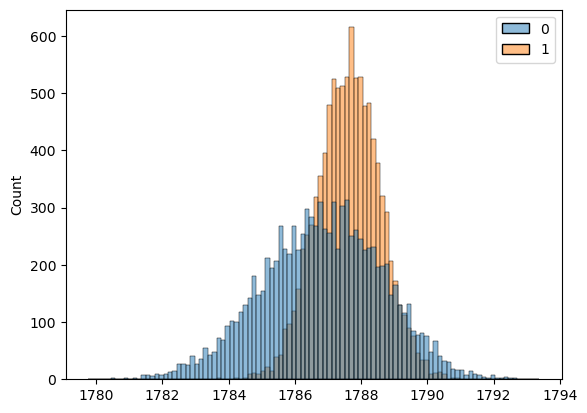

In [120]:
sns.histplot([means_administration, means_construction])

<AxesSubplot:xlabel='chef_annee_naissance', ylabel='Count'>

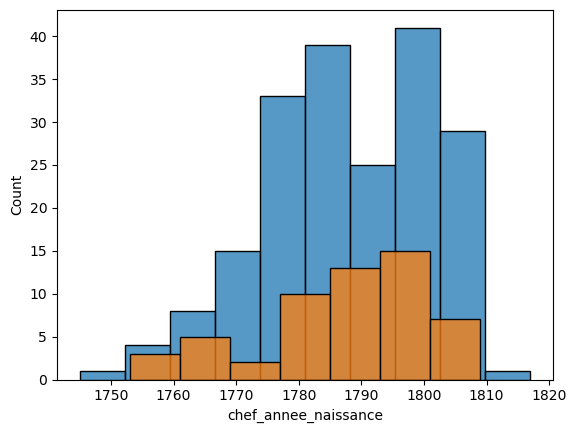

In [121]:
sns.histplot(df_new[df_new.chef_vocation_class == "construction"].chef_annee_naissance, label="construction")
sns.histplot(df_new[df_new.chef_vocation_class == "administration"].chef_annee_naissance, label="administration")

In [122]:
(1832 - df_new[df_new.chef_vocation_class == "administration"].chef_annee_naissance.mean(), 1832 - df_new[df_new.chef_vocation_class == "construction"].chef_annee_naissance.mean())

(45.16363636363644, 44.37755102040819)

In [123]:
df_new

,nom_rue,no_maison,proprietaire_nom,chef_prenom,chef_nom,chef_annee_naissance,epouse_nom,epouse_annee_naissance,enfants_dans_la_commune_prenom,enfants_annee_naissance,chef_origine,chef_annee_arrivee,chef_vocation,pensionnaires_prenom,pensionnaires_nom,pensionnaires_origine,Page,chef_vocation_class
1,marterey,1,weidmann,georges henri,weidmann,1764,·,·,·,·,tolochenaz,1786,charon,louise|anna|francois|jn adam,weidmann|la maurer|kirsner|reverber,tolochenaz|frutigen|cirol|bavarois,1,NaN
3,marterey,3,fiaux,louise,piot,1785,neissance,·,benjamin,1815,pailly,nee,lingere,·,·,·,1,service
5,marterey,·,fiaux,louis vincent,lavanchy,1802,baudet,1805,·,·,lutry,ne,garcon voiturier,·,·,·,1,NaN
7,marterey,·,fiaux,dominique,dubois,1797,·,·,·,·,nancy,1828,ebeniste,adolphine cecile|adolphine,borrely|borrely,paris|enfant de la che,1,NaN
8,marterey,·,fiaux,francois,fiaux,1787,blaud,·,felix|charles|ernestine,1826|·|1822,lausanne,ne,rentier,rose marie,metraux,pailly,1,rente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3697,montheron,·,martin,jean abraham,martin,1804,francoise,1804,henry|david,1829|1830,froideville,·,agriculteur,·,·,·,150,agricole
3698,montheron,·,martin,jean abram,blanc,1806,marie,1807,charles elie|louis jules,1829|1831,lausanne,1830,journalier,·,·,·,151,agricole
3699,les saugealles,·,commune de lausanne,veuve,tuller,1810,·,neene,jn louise|lse susanne|jean marc|jaques|ct fran...,1800|1803|1806|1808|1809|1812|1814,gessenay,1820,agriculteur,·,·,·,151,agricole
3700,chalet aux enfants,·,auberjonois,david,zbinden,1771,francoise,1773,·,·,guggisberg,·,agriculteur,·,·,·,151,agricole


In [124]:
df_new.describe()

,chef_annee_naissance,Page
count,2876.000000,2876.000000
mean,1785.815021,75.590751
std,14.056230,41.516083
min,1741.000000,1.000000
25%,1776.000000,42.000000
50%,1787.000000,77.000000
75%,1797.000000,109.000000
max,1824.000000,151.000000


In [125]:
df_new[df_new.chef_annee_naissance == 1824]

,nom_rue,no_maison,proprietaire_nom,chef_prenom,chef_nom,chef_annee_naissance,epouse_nom,epouse_annee_naissance,enfants_dans_la_commune_prenom,enfants_annee_naissance,chef_origine,chef_annee_arrivee,chef_vocation,pensionnaires_prenom,pensionnaires_nom,pensionnaires_origine,Page,chef_vocation_class
563,cheneau de bourg,·,maget,jean david,martin,1824,coulin,1804,francois|emmanuel,1828|1830,villeneuve,·,tanneur,louise,maillari,perey,22,artisanat


Find the proprietary that comes up the most frequently.

In [126]:
df_new.groupby("proprietaire_nom").size().sort_values(ascending=False)

proprietaire_nom
blanc             59
perrin            49
corbaz            46
regamey           40
martin            32
                  ..
decoppet           1
decombaz           1
de treytorrens     1
peyrollaz          1
pittet             1
Length: 597, dtype: int64